In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-10-10.0.19044-SP0


In [2]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

Tue May  2 16:30:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.37       Driver Version: 527.37       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     2W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
MyDrive = 'D:/COLLEGE SEM 8/Datasets'
PROJECT_DIR = 'D:/COLLEGE SEM 8/Datasets/Real Life Violence Situations dataset'

In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 112
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    # Frames to Be considered for each Dataset:
    # Fight Surf Data - 20
    # Bus Violence Data - 16
    # RWF 2000 Data - 60
    # RLVS Data - 20
    # Peliculas (Movies) - 30
    # Hockey Fights - 30
    # Crowd Violence - 20
    framerate = 20
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    multiplier = total_frames/framerate
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % multiplier < 1):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [5]:
x = video_to_frames("D:/COLLEGE SEM 8/Datasets/Real Life Violence Situations dataset/Violence/V_1.mp4")

In [6]:
import numpy as np
print(np.shape(x))

(20, 112, 112, 3)


In [7]:
y = video_to_frames("D:/COLLEGE SEM 8/Datasets/Real Life Violence Situations dataset/NonViolence/NV_1.mp4")

In [8]:
len(y)

20

In [9]:
#d = video_to_frames("/Users/tharunteja/Documents/SEM - 8/Fight Detection Surv dataset/Violence/fi007.mp4")

In [10]:
#len(d)

In [11]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []
print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["Violence", "NonViolence"]
#700 <- 350 + 350

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f
for category in listdir_nohidden(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    #path = VideoDataDir + category
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path))):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1005 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:02<00:00,  2.37it/s]

CPU times: total: 27min 39s
Wall time: 10min 54s


In [12]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

40100

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [14]:
!pip install imutils
clear_output()

In [15]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [16]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

Compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 56, 56, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 56, 56, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 56, 56, 32)   0           ['bn_Conv1

In [17]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 64

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [18]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeightsFullData.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [19]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50
502/502 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.5287
Epoch 1: val_loss improved from inf to 0.76773, saving model to ModelWeightsFullData.h5
502/502 [==============================] - 184s 354ms/step - loss: 0.8200 - accuracy: 0.5287 - val_loss: 0.7677 - val_accuracy: 0.5552 - lr: 1.0000e-05
Epoch 2/50
502/502 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.6145
Epoch 2: val_loss improved from 0.76773 to 0.64159, saving model to ModelWeightsFullData.h5
502/502 [==============================] - 159s 317ms/step - loss: 0.6897 - accuracy: 0.6145 - val_loss: 0.6416 - val_accuracy: 0.6498 - lr: 1.8000e-05
Epoch 3/50
502/502 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.6971
Epoch 3: val_loss improved from 0.64159 to 0.54766, saving model to ModelWeightsFullData.h5
502/502 [==============================] - 160s 318ms/step - loss: 0.5787 - accuracy: 0.6971 - val_loss: 0.5477 - val_a

In [20]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)        

------------------------------------------------------------------------------------------
Best Epochs:  38
Accuracy on train: 0.8703241944313049 	Loss on train: 0.3039103150367737
Accuracy on test: 0.8688279390335083 	Loss on test: 0.3063700497150421


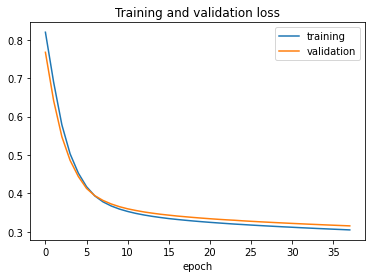

<Figure size 432x288 with 0 Axes>

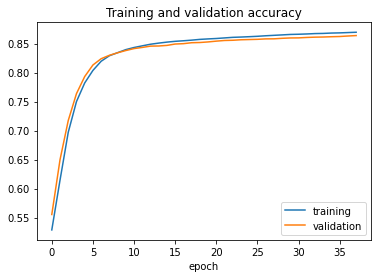

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [21]:
model_summary(model, history)

In [22]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
251/251 [==============================] - 34s 131ms/step


> Correct Predictions: 6968
> Wrong Predictions: 1052


C:\Users\vnktv.000\AppData\Local\Temp\ipykernel_6680\610348467.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
C:\Users\vnktv.000\AppData\Local\Temp\ipykernel_6680\610348467.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use

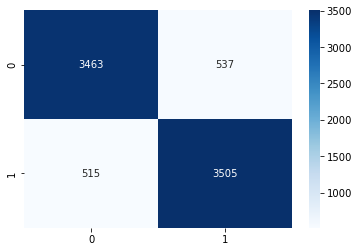

              precision    recall  f1-score   support

 NonViolence       0.87      0.87      0.87      4000
    Violence       0.87      0.87      0.87      4020

    accuracy                           0.87      8020
   macro avg       0.87      0.87      0.87      8020
weighted avg       0.87      0.87      0.87      8020



In [23]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [24]:
args_model = "D:/COLLEGE SEM 8/Saved_Models/MobilenetRLVSfulldata.h5"
model.save(args_model)